In [160]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F

import pandas as pd
import numpy as np
import math
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.preprocessing import normalize
import statsmodels.api as sm
from sklearn import preprocessing
import seaborn as sns
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn import linear_model
from sklearn import metrics
import matplotlib.pyplot as plt  

from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from pandas_profiling import ProfileReport

from copy import copy, deepcopy
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.feature_selection import SelectFromModel
import xgboost as xgb 




In [161]:
train_orig = pd.read_csv( "train_cleaned.csv" )
train_orig=pd.DataFrame(train_orig)
Y_train=deepcopy(train_orig["SalePrice"])
train=deepcopy(train_orig.drop(['SalePrice'],axis=1))
print("training data size = ", train.shape)
test_orig = pd.read_csv( "test_cleaned.csv" )
test_orig=pd.DataFrame(test_orig)
print("test data size = ", test_orig.shape)

training data size =  (1456, 131)
test data size =  (1459, 131)


### processing

In [162]:
#encode
def encodeCat(categoricalData):
    encodedCategoricalData=pd.get_dummies(deepcopy(categoricalData),columns=categoricalData.columns)
    return encodedCategoricalData

In [163]:
def boxcoxTransform(data):
    skew=data.skew(axis=0).sort_values(ascending=False)
    skewdic=dict(skew)
    fig,ax=plt.subplots(1,1,figsize=(20,6))
    sns.barplot(list(skewdic.keys()),list(skewdic.values()))
    skew=dict(skew[abs(skew)>0.5])
    for col in skew.keys():
        _,opt = boxcox(data[col]+1)
        data[col]=deepcopy(boxcox(data[col]+1,lmbda=opt))
    return data

In [164]:
def processData(train):
    categoricalData=deepcopy(train.select_dtypes(include='object'))    
    nonCategoricalData=deepcopy(train.select_dtypes(exclude='object'))
    encodedCategoricalData=encodeCat(deepcopy(categoricalData))
    #normalized=normalize(nonCategoricalData, norm='l2', axis=0, copy=True, return_norm=False)
    #nonCategoricalData=pd.DataFrame(normalized,index=nonCategoricalData.index,columns=nonCategoricalData.columns)
    #nonCategoricalData=boxcoxTransform(deepcopy(nonCategoricalData))
    nonCategoricalData=pd.concat([nonCategoricalData,encodedCategoricalData],axis=1)
    
    return nonCategoricalData

In [165]:
def sameSchema(X_train,X_test_orig):    
    #make sure the columns are the same and in same order
    for col in X_train.columns:
        if col not in X_test_orig.columns:
            X_test_orig[col]=np.zeros(X_test_orig.shape[0])
    X_test_orig=X_test_orig[X_train.columns]
    return X_test_orig

In [166]:
def remove_corr(data):
    corr_matrix = data.corr().abs()
    #sns.heatmap(corr_matrix,vmin=-1, vmax=1, center= 0)
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    lower = corr_matrix.where(np.tril(np.ones(corr_matrix.shape), k=-1).astype(np.bool))

    # Find index of feature columns with correlation greater than 0.95
    to_dropu = [column for column in upper.columns if any(abs(upper[column]) > 0.98)]
    to_dropl = [column for column in upper.columns if any(abs(lower[column]) > 0.98)]

    drop=to_dropu
    if(len(to_dropl)<len(to_dropu)):
        drop=to_dropl

    print(drop)

    #drop high corr columns
    data=data.drop(drop,axis=1)
    return data

In [167]:
#combine both data sets, process and then split again
train_size=len(train)
data=deepcopy(train)
data=data.append(test_orig,sort=False)
processed = processData(deepcopy(data))
#processed=remove_corr(deepcopy(processed))
X_train_processed=deepcopy(processed[:train_size])
test_orig_processed=deepcopy(processed[train_size:len(data)])
test_orig_processed = sameSchema(deepcopy(X_train_processed),deepcopy(test_orig_processed))

In [168]:
#trasnform Y
Y_train_processed=deepcopy(Y_train)
#Y_train_processed = np.log(Y_train)

### Select Imp Features

In [169]:
def featureSelector(X,Y,test,N=239):
    model=xgb.XGBRegressor()
    #model=BayesianRidge()
    model.fit(X,np.log(Y))
    imp = dict(zip(X.columns,model.feature_importances_))
    #imp = dict(zip(X_train_.columns,model.coef_))

    impsorted={k:v for k,v in sorted(imp.items(),key=lambda item:item[1],reverse=True)[:N]}
    newcols=impsorted.keys()
    return X[newcols],test[newcols]

In [170]:
X_train_processed_=deepcopy(X_train_processed)
test_orig_processed_=deepcopy(test_orig_processed)
X_train_processed,test_orig_processed=featureSelector(deepcopy(X_train_processed),deepcopy(Y_train_processed),\
                                                      deepcopy(test_orig_processed))

### Split into test and train

In [171]:
#split into test and train
X_train_, X_test_, Y_train_, Y_test_ = train_test_split(deepcopy(X_train_processed),\
                                                        deepcopy(Y_train_processed),\
                                                        test_size=0.2, random_state=0)
print("X_train_ shape = ", X_train_.shape)
print("Y_train_ shape = ", Y_train_.shape)
print("X_test_ shape = ", X_test_.shape)

X_train_ shape =  (1164, 239)
Y_train_ shape =  (1164,)
X_test_ shape =  (292, 239)


In [172]:
'''
#remove zero columns from train and the respective columns from test
X_train_ = deepcopy(X_train_.loc[:, (X_train_ != 0).any(axis=0)])
print("X_train shape after removing zeros = ", X_train_.shape)
#remove these columns from other datasets
X_test_= deepcopy(X_test_[X_train_.columns])
test_orig_processed=deepcopy(test_orig_processed[X_train_.columns])

print("X_train_ shape after removing zeros = ", X_train_.shape)
print("X_test_ shape after removing zeros = ", X_test_.shape)
print("test_orig_processed shape after removing zeros = ", test_orig_processed.shape)
'''

'\n#remove zero columns from train and the respective columns from test\nX_train_ = deepcopy(X_train_.loc[:, (X_train_ != 0).any(axis=0)])\nprint("X_train shape after removing zeros = ", X_train_.shape)\n#remove these columns from other datasets\nX_test_= deepcopy(X_test_[X_train_.columns])\ntest_orig_processed=deepcopy(test_orig_processed[X_train_.columns])\n\nprint("X_train_ shape after removing zeros = ", X_train_.shape)\nprint("X_test_ shape after removing zeros = ", X_test_.shape)\nprint("test_orig_processed shape after removing zeros = ", test_orig_processed.shape)\n'

### Model utils

In [173]:
def printErrors(Y_train,Y_pred):
    print('Root Mean Squared Log Error:', round(np.sqrt(metrics.mean_squared_error(np.log(Y_train), np.log(Y_pred))),5))
    #print('Mean % error:',round(np.sqrt(metrics.mean_squared_error((Y_train), (Y_pred)))/np.average((Y_pred))*100,2))
    print('Mean error:',round(np.sqrt(metrics.mean_squared_error((Y_train), (Y_pred)))))    

In [174]:
def saveOutput(y_pred):
    y_pred_df=pd.DataFrame()
    y_pred_df["Id"]=range(1461,1461+len(y_pred),1)
    y_pred_df["SalePrice"]=y_pred
    file = "my_submission.csv"
    y_pred_df.to_csv(file,index=False)
    print("saved to file :"+file)

In [175]:
def residualPlot(pred,actual):
    residual = pred - actual
    sns.scatterplot(x=actual,y=residual)

### Models

In [176]:
#model1
def linear_reg(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    regressor = LinearRegression()  
    regressor.fit(X_train_, Y_train_)
    print("------Simple linear regression model---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred_train=np.maximum(Y_pred,1)
    printErrors(Y_train_,Y_pred_train)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred_test=np.maximum(Y_pred,1)
    printErrors(Y_test_,Y_pred_test)
    
    Y_pred_dev=regressor.predict(test_orig_processed)
    Y_pred_dev=np.maximum(Y_pred_dev,1)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return regressor,Y_pred_train,Y_pred_test,Y_pred_dev

In [177]:
#model2
#same with logarithmic Y
def linear_reg_withlog(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    Y_train_exp=np.log(Y_train_)
    Y_test_exp=np.log(Y_test_)
    
    regressor = LinearRegression()  
    regressor.fit(X_train_, Y_train_exp)
    print("------Simple linear regression model with log---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred_train=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred_train)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred=np.exp(Y_pred)
    Y_pred_test=np.maximum(Y_pred,1)#TODO check why this is happening 
    #printErrors(Y_test_,Y_pred_test)

    Y_pred_dev=np.exp(regressor.predict(test_orig_processed))
    Y_pred_dev=np.maximum(Y_pred_dev,1)#TODO check why this is happening 
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return regressor,Y_pred_train,Y_pred_test,Y_pred_dev

In [178]:
#model3
#same with logarithmic Y
def ols_withlog(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    Y_train_exp=np.log(Y_train_)
    Y_test_exp=np.log(Y_test_)
    
    regressor = LinearRegression()  
    regressor = sm.OLS(Y_train_exp, X_train_).fit()
    print("------OLS model with log---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred_train=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred_train)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred_test=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred_test)
    
    Y_pred_dev=regressor.predict(test_orig_processed)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return regressor,Y_pred_train,Y_pred_test,Y_pred_dev

In [179]:
#model4
#same with logarithmic Y
def ols_withscale(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    Y_train_exp=np.log(Y_train_)

    regressor = LinearRegression()  
    regressor = sm.OLS(Y_train_exp, X_train_).fit()
    print("------OLS model outliers removed---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred_train=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred_train)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred_test=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred_test)
    
    Y_pred_dev=np.exp(regressor.predict(test_orig_processed))
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return regressor,Y_pred_train,Y_pred_test,Y_pred_dev

In [180]:
#model5
#same with logarithmic Y
def rfmodel(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    Y_train_exp=np.log(Y_train_)
    
    rf = RandomForestRegressor(n_estimators=500)
    rf.fit(X_train_, Y_train_exp)
    print("------random forest---------")
    print("Train Errors-")
    Y_pred=rf.predict(X_train_)
    Y_pred_train=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred_train)
    print("Test Errors-")
    Y_pred=rf.predict(X_test_)
    Y_pred_test=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred_test)
    
    Y_pred_dev=np.exp(rf.predict(test_orig_processed))
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return rf,Y_pred_train,Y_pred_test,Y_pred_dev

In [181]:
#model6
def lasso(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):

    
    Y_train_exp=np.log(Y_train_)
    lasso=linear_model.Lasso(max_iter=100000,normalize=False,alpha=0.0005,fit_intercept=True,tol=1e-2)
    lasso.fit(X_train_, Y_train_exp)
    print("------lasso---------")
    print("Train Errors-")
    Y_pred=lasso.predict(X_train_)
    Y_pred_train=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred_train)
    print("Test Errors-")
    Y_pred=lasso.predict(X_test_)
    Y_pred_test=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred_test)
    
    Y_pred_dev=np.exp(lasso.predict(test_orig_processed))
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return lasso,Y_pred_train,Y_pred_test,Y_pred_dev

In [182]:
#model7
def nnmodel(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    Y_train_exp=np.log(Y_train_)
    Y_train_exp = deepcopy([[y] for y in Y_train_exp])
    y_test_exp =np.log(Y_test_)
    y_test_exp = deepcopy([[y] for y in y_test_exp])
    
    #dimensions
    batch,dim,hidden,out = int(X_train_.shape[0]),int(X_train_.shape[1]),int(X_train_.shape[1]/2),1
    hidden=64
    #create input output tensors
    x = torch.tensor(X_train_.values)
    y = torch.tensor(Y_train_exp)
    y_test_tensor = torch.tensor(y_test_exp)
    lr = 1e-2
    epochs = 10000
    
    model = torch.nn.Sequential(
        torch.nn.Linear(dim, hidden),
        torch.nn.ReLU(),
        torch.nn.Linear(hidden, hidden),
        torch.nn.ReLU(),
        #torch.nn.Linear(math.floor(hidden), 64),
        #torch.nn.ReLU(),
        torch.nn.Linear(hidden,out)
    )
    model=model.float()
    loss_fn = torch.nn.MSELoss(reduction='mean')
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    train_loss =[]
    test_loss = []
    for i in range(epochs):
        pred=model(x.float())
        loss = loss_fn(pred,y.float())
        if i%1000==0:
            print(i,loss.item())
            train_loss.append([i,loss.item()])
            test_loss.append([i,loss_fn(model(torch.tensor(X_test_.values).float()),y_test_tensor.float()).item()])
    
        #reset gradients
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    
    print("------neural net 1hidden---------")
    print("Train Errors-")
    predy=model(x.float())
    Y_pred=predy.detach().numpy()    
    Y_pred_train=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred_train)
    #sns.scatterplot(pred-y.detach().numpy(),y.detach().numpy())
    print("Test Errors-")
    Y_pred=model(torch.tensor(X_test_.values).float())
    Y_pred=Y_pred.detach().numpy()    
    Y_pred_test=np.exp(Y_pred)
    printErrors(Y_test_,Y_pred_test)

    pred = model(torch.tensor(test_orig_processed.values).float())
    pred = pred.detach().numpy()
    Y_pred_dev=np.exp(pred)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return model,Y_pred_train,Y_pred_test,Y_pred_dev

In [183]:
#model8
def reg_with_xgboost(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    Y_train_exp=np.log(Y_train_)
    Y_test_exp=np.log(Y_test_)
    
    regressor = xgb.XGBRegressor(n_estimators=100,max_depth=5,nthread=2,rate_drop=0.001,one_drop=1,booster='dart',ntree_limit=20)
    regressor.fit(X_train_, Y_train_exp)
    print("------XGBoost with log---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred_train=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred_train)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred=np.exp(Y_pred)
    Y_pred_test=np.maximum(Y_pred,1)#TODO check why this is happening 
    printErrors(Y_test_,Y_pred_test)

    Y_pred_dev=np.exp(regressor.predict(test_orig_processed))
    Y_pred_dev=np.maximum(Y_pred_dev,1)#TODO check why this is happening 
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return regressor,Y_pred_train,Y_pred_test,Y_pred_dev

In [184]:
#model9
from sklearn.linear_model import BayesianRidge 
def bayesian(X_train_, X_test_, Y_train_, Y_test_,test_orig_processed, getOutputFile):
    Y_train_exp=np.log(Y_train_)
    Y_test_exp=np.log(Y_test_)
    
    regressor = BayesianRidge(tol=1e-5,n_iter=1000,copy_X=True,fit_intercept=True)
    regressor.fit(X_train_, Y_train_exp)
    print("------bayes---------")
    print("Train Errors-")
    Y_pred=regressor.predict(X_train_)
    Y_pred_train=np.exp(Y_pred)
    printErrors(Y_train_,Y_pred_train)
    print("Test Errors-")
    Y_pred=regressor.predict(X_test_)
    Y_pred=np.exp(Y_pred)
    Y_pred_test=np.maximum(Y_pred,1)#TODO check why this is happening 
    printErrors(Y_test_,Y_pred_test)

    Y_pred_dev=np.exp(regressor.predict(test_orig_processed))
    Y_pred_dev=np.maximum(Y_pred_dev,1)#TODO check why this is happening 
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return regressor,Y_pred_train,Y_pred_test,Y_pred_dev

In [185]:
linReg,Y_pred_train1,Y_pred_test1,Y_pred_dev1 = linear_reg(deepcopy(X_train_), deepcopy(X_test_), deepcopy(Y_train_), deepcopy(Y_test_),deepcopy(test_orig_processed), False)
linRegLog,Y_pred_train2,Y_pred_test2,Y_pred_dev2 = linear_reg_withlog(deepcopy(X_train_), deepcopy(X_test_), deepcopy(Y_train_), deepcopy(Y_test_),deepcopy(test_orig_processed), False)
#olsLog,Y_pred_train3,Y_pred_test3,Y_pred_dev3 = ols_withlog(deepcopy(X_train_), deepcopy(X_test_), deepcopy(Y_train_), deepcopy(Y_test_),deepcopy(test_orig_processed), False)
#olsLog1,Y_pred_train4,Y_pred_test4,Y_pred_dev4 = ols_withscale(deepcopy(X_train_), deepcopy(X_test_), deepcopy(Y_train_), deepcopy(Y_test_),deepcopy(test_orig_processed), False)
#rf,Y_pred_train5,Y_pred_test5,Y_pred_dev5 = rfmodel(deepcopy(X_train_), deepcopy(X_test_), deepcopy(Y_train_), deepcopy(Y_test_),deepcopy(test_orig_processed), True)
#lasso,Y_pred_train6,Y_pred_test6,Y_pred_dev6 = lasso(deepcopy(X_train_), deepcopy(X_test_), deepcopy(Y_train_), deepcopy(Y_test_),deepcopy(test_orig_processed), True)
#nnmod,Y_pred_train7,Y_pred_test7,Y_pred_dev7 = nnmodel(deepcopy(X_train_), deepcopy(X_test_), deepcopy(Y_train_), deepcopy(Y_test_),deepcopy(test_orig_processed), True)
xgmodel,Y_pred_train8,Y_pred_test8,Y_pred_dev8 = reg_with_xgboost(deepcopy(X_train_), deepcopy(X_test_), deepcopy(Y_train_), deepcopy(Y_test_),deepcopy(test_orig_processed), True)
bayes,Y_pred_train9,Y_pred_test9,Y_pred_dev9 = bayesian(deepcopy(X_train_), deepcopy(X_test_), deepcopy(Y_train_), deepcopy(Y_test_),deepcopy(test_orig_processed), True)


------Simple linear regression model---------
Train Errors-
Root Mean Squared Log Error: 0.10445
Mean error: 17999.0
Test Errors-
Root Mean Squared Log Error: 0.13073
Mean error: 23946.0
------Simple linear regression model with log---------
Train Errors-
Root Mean Squared Log Error: 0.08954
Mean error: 16656.0
Test Errors-
------XGBoost with log---------
Train Errors-
Root Mean Squared Log Error: 0.03697
Mean error: 6634.0
Test Errors-
Root Mean Squared Log Error: 0.11428
Mean error: 22602.0
Saving output for upload
saved to file :my_submission.csv
------bayes---------
Train Errors-
Root Mean Squared Log Error: 0.09834
Mean error: 17810.0
Test Errors-
Root Mean Squared Log Error: 0.10267
Mean error: 19809.0
Saving output for upload
saved to file :my_submission.csv


STD in Train Error 17783.556594006834
STD in Test Error 19776.690617977463


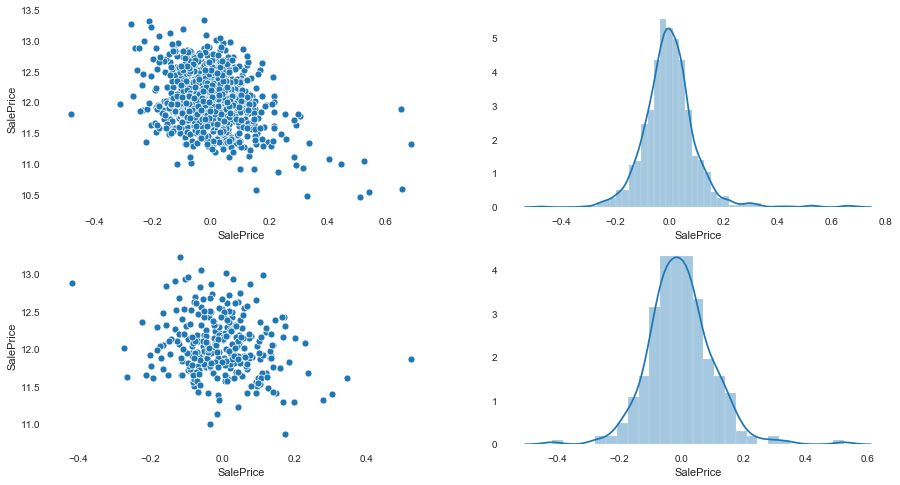

In [186]:
#plot residuals
#residualPlot(linReg.predict(X_train_),Y_train_)
#residualPlot(np.exp(linRegLog.predict(X_train_)),Y_train_)
fig,ax=plt.subplots(2,2,figsize=(15,8))
prediction =Y_pred_train9
prediction_test =Y_pred_test9

sns.scatterplot(np.log(prediction)-np.log(Y_train_),np.log(Y_train_),ax=ax[0,0])
sns.distplot(np.log(prediction)-np.log(Y_train_),ax=ax[0,1])
sns.scatterplot(np.log(prediction_test)-np.log(Y_test_),np.log(Y_test_),ax=ax[1,0])
sns.distplot(np.log(prediction_test)-np.log(Y_test_),ax=ax[1,1])
print("STD in Train Error",np.sqrt(np.var(prediction-Y_train_)))
print("STD in Test Error",np.sqrt(np.var(prediction_test-Y_test_)))

## Stacking Models now

In [187]:

newTrain_train=pd.DataFrame()
newTrain_train['LinReg']=np.array(Y_pred_train1)
#newTrain_train['LinRegLog']=np.array(Y_pred_train2)
#newTrain_train['OLS']=np.array(Y_pred_train3)
#newTrain_train['OLSLog']=np.array(Y_pred_train4)
#newTrain_train['RF']=np.array(Y_pred_train5)
#newTrain_train['lasso']=Y_pred_train6
#newTrain_train['NN']=np.array(Y_pred_train7)
newTrain_train['XG']=np.array(Y_pred_train8)
newTrain_train['BY']=np.array(Y_pred_train9)


print(newTrain_train.shape)
newYTrain_train=np.array(Y_train_)
print(newYTrain_train.shape)

trainingdata=newTrain_train
trainingtarget=newYTrain_train

(1164, 3)
(1164,)


In [188]:

newTrain=pd.DataFrame()
newTrain['LinReg']=np.array(Y_pred_test1)
#newTrain['LinRegLog']=np.array(Y_pred_test2)
#newTrain['OLS']=np.array(Y_pred_test3)
#newTrain['OLSLog']=np.array(Y_pred_test4)
#newTrain['RF']=np.array(Y_pred_test5)
#newTrain['lasso']=Y_pred_test6
#newTrain['NN']=np.array(Y_pred_test7)
newTrain['XG']=np.array(Y_pred_test8)
newTrain['BY']=np.array(Y_pred_test9)



print(newTrain.shape)
newYTrain=np.array(Y_test_)
print(Y_test_.shape)
trainingdata=newTrain
trainingtarget=newYTrain


(292, 3)
(292,)


In [189]:
newTest=pd.DataFrame()
newTest['LinReg']=np.array(Y_pred_dev1)
#newTest['LinRegLog']=np.array(Y_pred_dev2)
#newTest['OLS']=np.array(Y_pred_dev3)
#newTest['OLSLog']=np.array(Y_pred_dev4)
#newTest['RF']=np.array(Y_pred_dev5)
#newTest['lasso']=np.array(Y_pred_dev6)
#newTest['NN']=np.array(Y_pred_dev7)
newTest['XG']=np.array(Y_pred_dev8)
newTest['BY']=np.array(Y_pred_dev9)



print(newTest.shape)

(1459, 3)


In [190]:
def adaboostStack(newTrain,newYTrain,newTest,getOutputFile):
    lr = 0.05
    #newYTrainExp=np.log(newYTrain)
    reg=AdaBoostRegressor(loss='square',n_estimators=1000,learning_rate=lr)
    reg.fit(newTrain,newYTrain)
    y_pred_train = reg.predict(newTrain)
    y_pred_train=np.maximum(y_pred_train,0)
    #y_pred_train=np.exp(y_pred_train)
    printErrors(newYTrain,y_pred_train)
    
    Y_pred_dev=reg.predict(newTest)
    #Y_pred_dev=np.exp(Y_pred_dev)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return reg

In [191]:
def rfStack(newTrain,newYTrain,newTest,getOutputFile):
    lr = 0.05
    #newYTrainExp=np.log(newYTrain)
    reg=RandomForestRegressor(n_estimators = 1000,warm_start=True)
    reg.fit(newTrain,newYTrain)
    y_pred_train = reg.predict(newTrain)
    y_pred_train=np.maximum(y_pred_train,0)
    #y_pred_train=np.exp(y_pred_train)
    print("rf stack")
    printErrors(newYTrain,y_pred_train)
    
    Y_pred_dev=reg.predict(newTest)
    #Y_pred_dev=np.exp(Y_pred_dev)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return reg

In [192]:
def rfStack_exp(newTrain,newYTrain,newTest,getOutputFile):
    lr = 0.05
    newYTrainExp=np.log(newYTrain)
    reg=RandomForestRegressor(n_estimators = 10000)
    reg.fit(newTrain,newYTrainExp)
    y_pred_train = reg.predict(newTrain)
    y_pred_train=np.exp(y_pred_train)
    print("rf stack exp")
    printErrors(newYTrain,y_pred_train)
    
    Y_pred_dev=reg.predict(newTest)
    Y_pred_dev=np.exp(Y_pred_dev)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return reg

In [193]:
def xgStack_exp(newTrain,newYTrain,newTest,getOutputFile):
    newYTrainExp=np.log(newYTrain)
    reg=xgb.XGBRegressor()
    reg.fit(newTrain,newYTrainExp)
    y_pred_train = reg.predict(newTrain)
    y_pred_train=np.maximum(y_pred_train,0)
    y_pred_train=np.exp(y_pred_train)
    print("xgb")
    printErrors(newYTrain,y_pred_train)
    
    Y_pred_dev=reg.predict(newTest)
    Y_pred_dev=np.exp(Y_pred_dev)
    if(getOutputFile==True):
        print("Saving output for upload")
        saveOutput(Y_pred_dev)
    return reg

In [194]:
#booststack = adaboostStack(trainingdata,trainingtarget,newTest,True)
#rfstack = rfStack(trainingdata,trainingtarget,newTest,True)
#rfstackexp = rfStack_exp(trainingdata,trainingtarget,newTest,True)
#xgstackexp = xgStack_exp(trainingdata,trainingtarget,newTest,True)

### Choose a model and run it on all data for submission

In [195]:
def runselectedModel(model,X_train_processed,Y_train_processed,test_orig_processed):
    Y_train=np.log(Y_train_processed)
    model.fit(X_train_processed,Y_train)
    
    Y_pred=model.predict(X_train_processed)
    Y_pred=np.exp(Y_pred)
    Y_pred_test=np.maximum(Y_pred,1)#TODO check why this is happening 
    printErrors(Y_train_processed,Y_pred_test)
    
    Y_pred_dev=model.predict(test_orig_processed)
    Y_pred_dev=np.exp(Y_pred_dev)
    print("Saving output for upload")
    saveOutput(Y_pred_dev)

In [196]:
runselectedModel(bayes,deepcopy(X_train_processed),deepcopy(Y_train_processed),deepcopy(test_orig_processed))
prediction = pd.read_csv( "my_submission.csv" )
prediction=pd.DataFrame(prediction)
actual = pd.read_csv( "full-score.csv" )
actual=pd.DataFrame(actual)
printErrors(prediction['SalePrice'],actual['SalePrice'])

Root Mean Squared Log Error: 0.09756
Mean error: 17870.0
Saving output for upload
saved to file :my_submission.csv
Root Mean Squared Log Error: 0.12641
Mean error: 27992.0


### Get relevant features and run again

In [197]:
#imp = dict(zip(X_train_.columns,xgmodel.feature_importances_))
imp = dict(zip(X_train_.columns,bayes.coef_))
best=[74,79]#
impsorted={k:v for k,v in sorted(imp.items(),key=lambda item:item[1],reverse=True)[:100]}
newcols=impsorted.keys()

In [198]:
bayes2,Y_pred_train8,Y_pred_test8,Y_pred_dev8 = bayesian(deepcopy(X_train_[newcols]), deepcopy(X_test_[newcols]),\
                                                           deepcopy(Y_train_), deepcopy(Y_test_),\
                                                           deepcopy(test_orig_processed[newcols]), True)

------bayes---------
Train Errors-
Root Mean Squared Log Error: 0.10404
Mean error: 18805.0
Test Errors-
Root Mean Squared Log Error: 0.10319
Mean error: 19992.0
Saving output for upload
saved to file :my_submission.csv


In [199]:
runselectedModel(bayes2,deepcopy(X_train_processed[newcols]),deepcopy(Y_train_processed),\
                 deepcopy(test_orig_processed[newcols]))
prediction = pd.read_csv( "my_submission.csv" )
prediction=pd.DataFrame(prediction)
actual = pd.read_csv( "full-score.csv" )
actual=pd.DataFrame(actual)
printErrors(prediction['SalePrice'],actual['SalePrice'])

Root Mean Squared Log Error: 0.103
Mean error: 18729.0
Saving output for upload
saved to file :my_submission.csv
Root Mean Squared Log Error: 0.12385
Mean error: 26434.0
